# internal tide, delayed experiments

In [1]:
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline

import crocosi.postp as pp

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*4)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.43:39823 Dashboard: http://10.148.1.43:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
## utils

In [3]:
# apply ufunc

def filter_omega(v, dt, Twin, Twin_one):

    t = np.arange(0,Twin,dt)

    def filter_one_location(v):
        # need to substract running mean value first, otherwise mean sign on cos projection
        # downside: this doubles side effects
        win_one = t[np.where(t<Twin_one)]*0.+1
        win_one = win_one/np.sum(win_one**2)
        v_low = np.convolve(win_one, v, mode='same')

        omega = 2.*2.*np.pi # rad/day
        win = np.cos(omega*t)
        win = win/np.sum(win**2)
        v_omega = np.convolve(win, v-v_low, mode='valid')
        return v_omega
    
    # loop over all dimensions but the last one to apply correlate
    Ni = v.shape[:-1]
    # infer number of lags from dummy computation
    vv = np.full(Ni+tuple([v.shape[-1]]), np.NaN)
    for ii in np.ndindex(Ni):
        f = filter_one_location(v[ii + np.s_[:,]])
        Nj = f.shape
        for jj in np.ndindex(Nj):
            vv[ii + jj] = f[jj]
            
    return vv


def wrap_filter(v, Twin=2, Twin_one=1):
    v = v.chunk({'time': -1})
    dt = (v.time[1]-v.time[0]).values
    out = xr.apply_ufunc(filter_omega, v, dt, Twin, Twin_one,
                         dask='parallelized',
                         input_core_dims=[['time'],[],[],[]],
                         output_core_dims=[['time']],
                         output_dtypes=[np.float64])
    return out

---
## process all runs

In [4]:
#root_path = '/home/c11-data/Test_aponte/jetn/'
#root_path = '/home1/scratch/aponte/'
root_path = '/home/datawork-lops-osi/equinox/jetn/'

nmode = 2
ix=0

runs = ([root_path+'jet_wp5_ptb_m1_p4'] + 
        [root_path+'jet_wp5_dstart_m%d_%d'%(nmode, i) for i in range(4)]
       )

# these should be derived from params_output but online param float output should be improved
start_shifts = [0, 0.5, 1, 2, 4]

R = []
V = []
for r in runs:
    _r = pp.Run(r, open_nc=['surf'])
    _r['surf'] = _r['surf'].rename({'time_instant': 'time'})
    R.append(_r)
    V.append(_r['surf'].ssh
              .isel(x_rho=ix)
              .chunk({'y_rho': 10, 'time': -1})
              .persist())

In [5]:
V_omega = [wrap_filter(v) for v in V]
V_omega = [v.assign_coords(y=v.y_rho/1e3).persist() for v in V_omega]

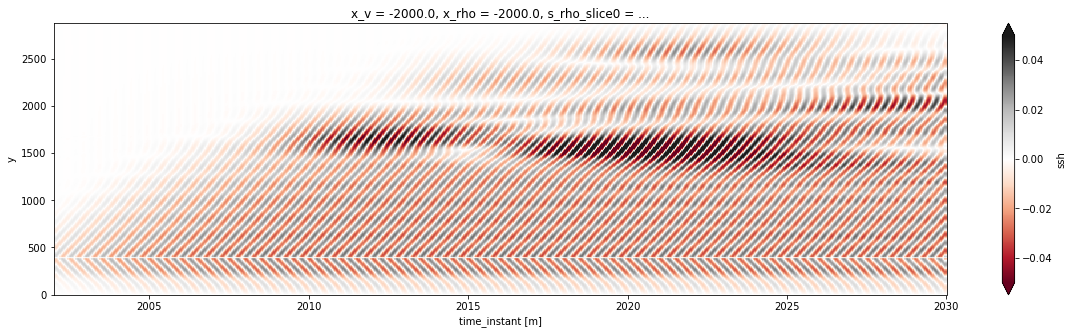

In [6]:
pkw = {'vmin': -.05, 'vmax': .05, 'cmap': 'RdGy', 'xlim': (2002,2030), 'figsize': (20,5)}
((V_omega[0]).isel(time=slice(2*24*6,30*24*6,6))
    .plot(x='time', y='y', **pkw)
)

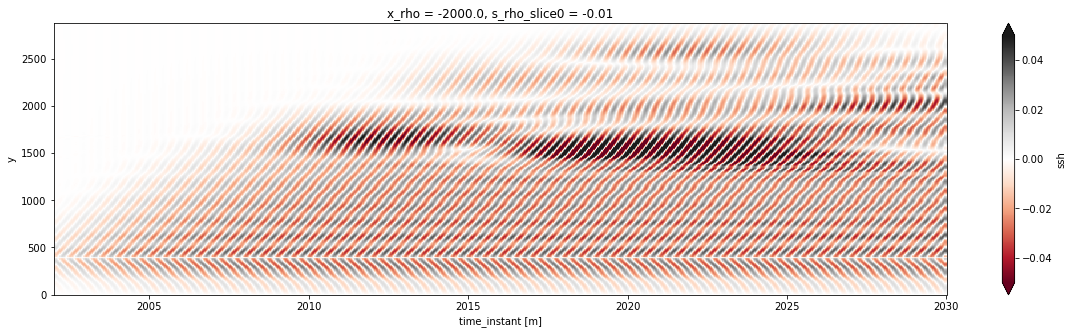

In [7]:
i=1
((V_omega[i].shift(time=-int(start_shifts[i]*24*6))-V_omega[0])
  .isel(time=slice(2*24*6,30*24*6,6))
  .plot(x='time', y='y', **pkw)
)

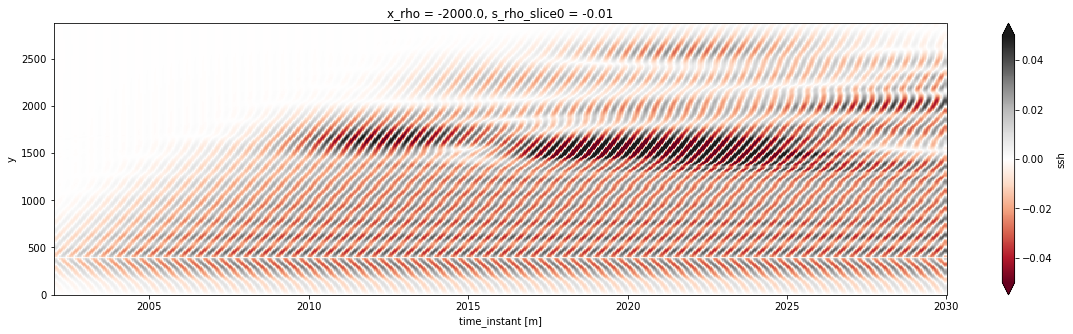

In [8]:
i=2
((V_omega[i].shift(time=-int(start_shifts[i]*24*6))-V_omega[0])
  .isel(time=slice(2*24*6,30*24*6,6))
  .plot(x='time', y='y', **pkw)
)

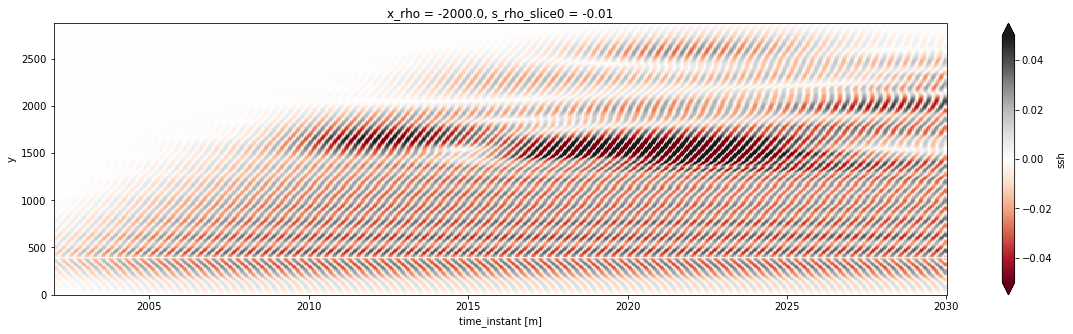

In [9]:
i=3
((V_omega[i].shift(time=-int(start_shifts[i]*24*6))-V_omega[0])
  .isel(time=slice(2*24*6,30*24*6,6))
  .plot(x='time', y='y', **pkw)
)

In [10]:
dV_omega = [(v.shift(time=-int(s*24*6))-V_omega[0])
            .isel(time=slice(2*24*6,30*24*6,6))
            for s, v in zip(start_shifts[1:], V_omega[1:])]

In [11]:
dV_omega = xr.concat(dV_omega, dim='shift').assign_coords(shift=start_shifts[1:])

NameError: name 'nlin' is not defined

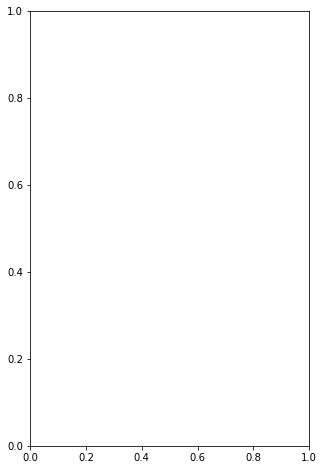

In [12]:
ax = plt.subplots(1, figsize=(5,8))
nlin.plot(y='y', color='orange')
# add internal tide amplitude
lin.isel(amplitude=0).plot(y='y', color='k')
ax[1].set_title('')
ax[1].grid()

In [ ]:
dV_omega.std('time').plot.line(y='y_rho')
(V_omega[0].isel(time=slice(2*24*6,30*24*6,6))
 .std('time')
 .plot(y='y_rho', color='k')
)

In [17]:
#root_path = '/home/c11-data/Test_aponte/jetn/'
#root_path = '/home1/scratch/aponte/'
root_path = '/home/datawork-lops-osi/equinox/jetn/'

nmode = 2
ix=0

runs = ([root_path+'jet_wp5_ptb_m%d_p4'%nmode] + 
        [root_path+'jet_wp5_dstart_m%d_%d'%(nmode, i) for i in range(4)]
       )

# these should be derived from params_output but online param float output should be improved
start_shifts = [0, 0.5, 1, 2, 4]

R = []
V = []
for s, r in zip(start_shifts, runs):
    _r = pp.Run(r, open_nc=['surf'])
    _r['surf'] = _r['surf'].rename({'time_instant': 'time'})
    R.append(_r)
    v = (_r['surf'].ssh
              .chunk({'x_rho':10, 'y_rho': 10, 'time': -1}))
    if s>0:
        v_omega = wrap_filter(v).shift(time=-int(s*24*6)) - v_omega0
    else:
        v_omega = wrap_filter(v)
        v_omega0 = v_omega
        
    _std = ( v_omega.isel(time=slice(2*24*6,30*24*6,6))
             .std(dim=['x_rho','time']) )
    _std = _std.assign_coords(y=_std.y_rho/1e3).persist()
    V.append(_std)
    
    print('shift %.2f done' %s)

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


shift 0.00 done


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

shift 0.50 done


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


shift 1.00 done


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


shift 2.00 done


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


shift 4.00 done


In [20]:
V

[<xarray.DataArray 'ssh' (y_rho: 722)>
 dask.array<sqrt, shape=(722,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
 Coordinates:
   * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
     y_u           (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
     s_rho_slice0  float32 -0.01
     f_rho         (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
     f_u           (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
     y             (y_rho) float32 -2.0 2.0 6.0 10.0 ... 2874.0 2878.0 2882.0,
 <xarray.DataArray 'ssh' (y_rho: 722)>
 dask.array<sqrt, shape=(722,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
 Coordinates:
   * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
     y_u           (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
     s_rho_slice0  float32 -0.01
     f_rho         (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
     f_u

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


In [22]:
Nc = len(V[1:])

cmap = 'plasma'
scalarMap = cmx.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=Nc),
                               cmap=cmap)
cols = [scalarMap.to_rgba(i) for i in range(Nc)]

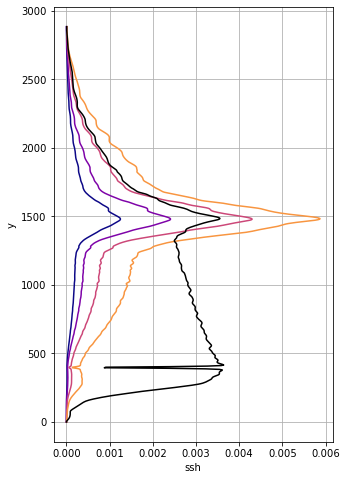

In [23]:
ax = plt.subplots(1, figsize=(5,8))
for v, c in zip(V[1:],cols):
    v.plot(y='y', color=c)
# add internal tide amplitude
V[0].plot(y='y', color='k')
ax[1].set_title('')
ax[1].grid()

---

In [ ]:
cluster.close()

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
